In [ ]:
import pandas as pd
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

In [240]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [241]:
train_df.head(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [245]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [246]:
def convert_str_to_num(df, column):
    entry_dict = {}
    unique_entries = list(df[column].unique())
    for idx, value in enumerate(unique_entries):
        entry_dict[value if isinstance(value, str) else str(value)] = idx
    for value in entry_dict:
        df[column] = df[column].replace(value, entry_dict[value])
    return df

In [247]:
train_df = convert_str_to_num(train_df.copy(), 'Sex')
train_df = convert_str_to_num(train_df.copy(), 'Cabin')
train_df = convert_str_to_num(train_df.copy(), 'Embarked')

test_df = convert_str_to_num(test_df.copy(), 'Sex')
test_df = convert_str_to_num(test_df.copy(), 'Cabin')
test_df = convert_str_to_num(test_df.copy(), 'Embarked')

In [248]:
input_columns = ['Pclass', 'Sex', 'Age', 'Cabin', 'Embarked']

def create_dataset(df, test=False):
    input_values = []
    labels = []

    for _, row in df.iterrows():
        input_ = []
        if not test:
            labels.append([row['Survived']])
        for column in input_columns:
            input_.append(row[column])
        input_values.append(input_)
    return np.array(input_values), np.array(labels)

In [249]:
train_input, train_labels = create_dataset(train_df)
test_input, _ = create_dataset(test_df,test=True)

In [250]:
model = Sequential()
model.add(layers.Dense(16, input_shape=(5,), activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [251]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [252]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 16)                96        
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_80 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_81 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 65        
Total params: 13,185
Trainable params: 13,185
Non-trainable params: 0
_________________________________________________

In [253]:
history = model.fit(train_input, train_labels, validation_split=0.1, epochs=80)

Epoch 1/80
26/26 [==============================] - 1s 18ms/step - loss: 0.7419 - accuracy: 0.5855 - val_loss: 0.6648 - val_accuracy: 0.7333
Epoch 2/80
26/26 [==============================] - 0s 10ms/step - loss: 0.7030 - accuracy: 0.6080 - val_loss: 0.6078 - val_accuracy: 0.7333
Epoch 3/80
26/26 [==============================] - 0s 11ms/step - loss: 0.7095 - accuracy: 0.6017 - val_loss: 0.6752 - val_accuracy: 0.7333
Epoch 4/80
26/26 [==============================] - 0s 9ms/step - loss: 0.6907 - accuracy: 0.6567 - val_loss: 0.6215 - val_accuracy: 0.7333
Epoch 5/80
26/26 [==============================] - 0s 8ms/step - loss: 0.7114 - accuracy: 0.6380 - val_loss: 0.6185 - val_accuracy: 0.7222
Epoch 6/80
26/26 [==============================] - 0s 6ms/step - loss: 0.6437 - accuracy: 0.6679 - val_loss: 0.6952 - val_accuracy: 0.6222
Epoch 7/80
26/26 [==============================] - 0s 10ms/step - loss: 0.6702 - accuracy: 0.6554 - val_loss: 0.6262 - val_accuracy: 0.6778
Epoch 8/80
26/26

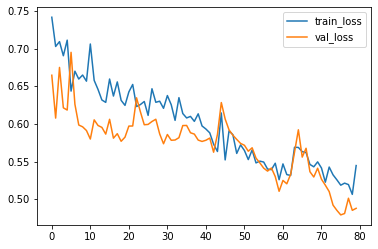

In [254]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

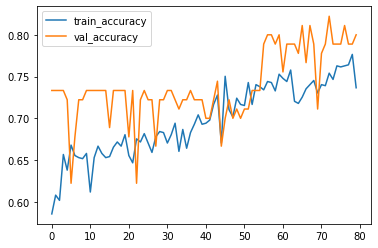

In [255]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
for test_data in test_input:
    prediction = model.predict(test_data)
    if prediction > 0.5:
        print("dead")
    else:
        print("alive")